In [1]:
import numpy as np
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [ ]:
'''
SELECT 
    s.asset_id, s.created_at, from_unixtime(s.created_at) as created_at_datetime, s.spectrum_x_amp, s.spectrum_y_amp, s.spectrum_z_amp,
    h.asset_health
FROM 
    ics_asset_wavedata s
JOIN 
    ics_asset_status_hist h 
ON 
	s.asset_id = h.asset_id  -- asset_id 기준으로 조인
    AND DATE(FROM_UNIXTIME(s.created_at)) + INTERVAL 1 DAY = DATE(h.time)  -- sig의 날짜가 hist의 날짜의 하루 전이 맞도록 조인
WHERE 
   FROM_UNIXTIME(s.created_at) >= h.time - INTERVAL 1 DAY
    AND FROM_UNIXTIME(s.created_at) < h.time
    AND s.asset_id = '02dc4105-ca5e-4770-a6fc-d1fdff11fc1c'  -- asset_id 일치하는 것만
    AND h.asset_health IS NOT NULL  -- asset_health가 null이 아닌 것만
ORDER BY s.created_at;
'''

In [12]:
data = pd.read_csv('data/wavedata_test.csv')
data.head()

,asset_id,created_at,created_at_datetime,spectrum_x_amp,spectrum_y_amp,spectrum_z_amp,asset_health
0,02dc4105-ca5e-4770-a6fc-d1fdff11fc1c,1704040841,2024-01-01 01:40:41,"0.00031107705436700085,0.00042369687475733264,...","0.0001889452687150325,0.00015548185862793095,0...","0.0002630090400462783,0.0003323863352001216,0....",1.0
1,02dc4105-ca5e-4770-a6fc-d1fdff11fc1c,1704048050,2024-01-01 03:40:50,"0.00016408581402789447,0.00013823651341021877,...","0.00011324375281718903,0.00022926379993861015,...","0.000022369037315370793,0.00005101995505648931...",1.0
2,02dc4105-ca5e-4770-a6fc-d1fdff11fc1c,1704055252,2024-01-01 05:40:52,"0.00014058241262894205,0.0001754323000081747,0...","0.0001868651846033509,0.00022667048172826684,0...","0.0002523945829317108,0.00047809901073257293,0...",1.0
3,02dc4105-ca5e-4770-a6fc-d1fdff11fc1c,1704062461,2024-01-01 07:41:01,"0.00015381071019018514,0.00018861300190610732,...","0.000041520068673435925,0.000235236489262718,0...","0.000014814900177851487,0.00001326179532181423...",1.0
4,02dc4105-ca5e-4770-a6fc-d1fdff11fc1c,1704069663,2024-01-01 09:41:03,"0.000012294286417780833,0.00009377909991218348...","0.00013873443693364321,0.00010078990071126736,...","0.00015754902533475447,0.0003424379403160593,0...",1.0


In [13]:
data['created_at'] = pd.to_datetime(data['created_at'], unit='s') + timedelta(hours=9)
data = data.sort_values(by='created_at')

In [14]:
X = data.drop(columns=['asset_id','created_at_datetime', 'asset_health'])
y = data.iloc[:, -1:]
y = y.values.ravel()
X.set_index(['created_at'], inplace=True)

In [15]:
X.head()

,spectrum_x_amp,spectrum_y_amp,spectrum_z_amp
created_at,,,
2024-01-01 01:40:41,"0.00031107705436700085,0.00042369687475733264,...","0.0001889452687150325,0.00015548185862793095,0...","0.0002630090400462783,0.0003323863352001216,0...."
2024-01-01 03:40:50,"0.00016408581402789447,0.00013823651341021877,...","0.00011324375281718903,0.00022926379993861015,...","0.000022369037315370793,0.00005101995505648931..."
2024-01-01 05:40:52,"0.00014058241262894205,0.0001754323000081747,0...","0.0001868651846033509,0.00022667048172826684,0...","0.0002523945829317108,0.00047809901073257293,0..."
2024-01-01 07:41:01,"0.00015381071019018514,0.00018861300190610732,...","0.000041520068673435925,0.000235236489262718,0...","0.000014814900177851487,0.00001326179532181423..."
2024-01-01 09:41:03,"0.000012294286417780833,0.00009377909991218348...","0.00013873443693364321,0.00010078990071126736,...","0.00015754902533475447,0.0003424379403160593,0..."


In [16]:
X['spectrum_x_amp'] = X['spectrum_x_amp'].apply(lambda x: [float(i) for i in x.split(',')])
X['spectrum_y_amp'] = X['spectrum_y_amp'].apply(lambda x: [float(i) for i in x.split(',')])
X['spectrum_z_amp'] = X['spectrum_z_amp'].apply(lambda x: [float(i) for i in x.split(',')])

spectrum_x_amp = np.array(X['spectrum_x_amp'].tolist())
spectrum_y_amp = np.array(X['spectrum_y_amp'].tolist())
spectrum_z_amp = np.array(X['spectrum_z_amp'].tolist())

In [ ]:
X = np.hstack([spectrum_x_amp, spectrum_y_amp, spectrum_z_amp])

In [18]:
X[0:5]

,spectrum_x_amp,spectrum_y_amp,spectrum_z_amp
created_at,,,
2024-01-01 01:40:41,"[0.00031107705436700085, 0.0004236968747573326...","[0.0001889452687150325, 0.00015548185862793095...","[0.0002630090400462783, 0.0003323863352001216,..."
2024-01-01 03:40:50,"[0.00016408581402789447, 0.0001382365134102187...","[0.00011324375281718903, 0.0002292637999386101...","[2.2369037315370793e-05, 5.101995505648931e-05..."
2024-01-01 05:40:52,"[0.00014058241262894205, 0.0001754323000081747...","[0.0001868651846033509, 0.00022667048172826684...","[0.0002523945829317108, 0.00047809901073257293..."
2024-01-01 07:41:01,"[0.00015381071019018514, 0.0001886130019061073...","[4.1520068673435925e-05, 0.000235236489262718,...","[1.4814900177851487e-05, 1.3261795321814236e-0..."
2024-01-01 09:41:03,"[1.2294286417780833e-05, 9.377909991218348e-05...","[0.00013873443693364321, 0.0001007899007112673...","[0.00015754902533475447, 0.0003424379403160593..."


In [24]:
print(X.shape)
print(y.shape)
print(type(X))
print(type(y))

(2696, 6147)
(2696,)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [27]:
# reg = RandomForestRegressor(n_estimators=100, max_depth=2)
# reg.fit(data, target)


# 하이퍼파라미터 그리드 정의
param_grid = {
    'max_depth': [2,3,4],
    'n_estimators':[100,200]
}

# GridSearchCV 객체 생성
reg = RandomForestRegressor()
grid_search = GridSearchCV(estimator=reg, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, error_score='raise')
grid_search.fit(X, y)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5, error_score='raise', estimator=RandomForestRegressor(),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4], 'n_estimators': [100, 200]},
             verbose=2)

In [36]:
# 최적 모델 가져오기
best_model = grid_search.best_estimator_

# 특성 중요도 추출
importances = best_model.feature_importances_

features = ['spectrum_x_amp', 'spectrum_y_amp', 'spectrum_z_amp']

# plt.figure(figsize=(15, 5))
# plt.title('Feature Importance')
# plt.bar(range(X.shape[1]), grid_imp[indices], align='center')
# plt.xticks(range(X.shape[1]), np.array(features)[indices], rotation=90)
# plt.xlim([-1, X.shape[1]])
# plt.show()

In [42]:
reg = RandomForestRegressor(max_depth=2, n_estimators=100)
reg.fit(X, y)

RandomForestRegressor(max_depth=2)

In [46]:
print(f"Train Score: {reg.score(X,y)}")

Train Score: 0.18986698420888137


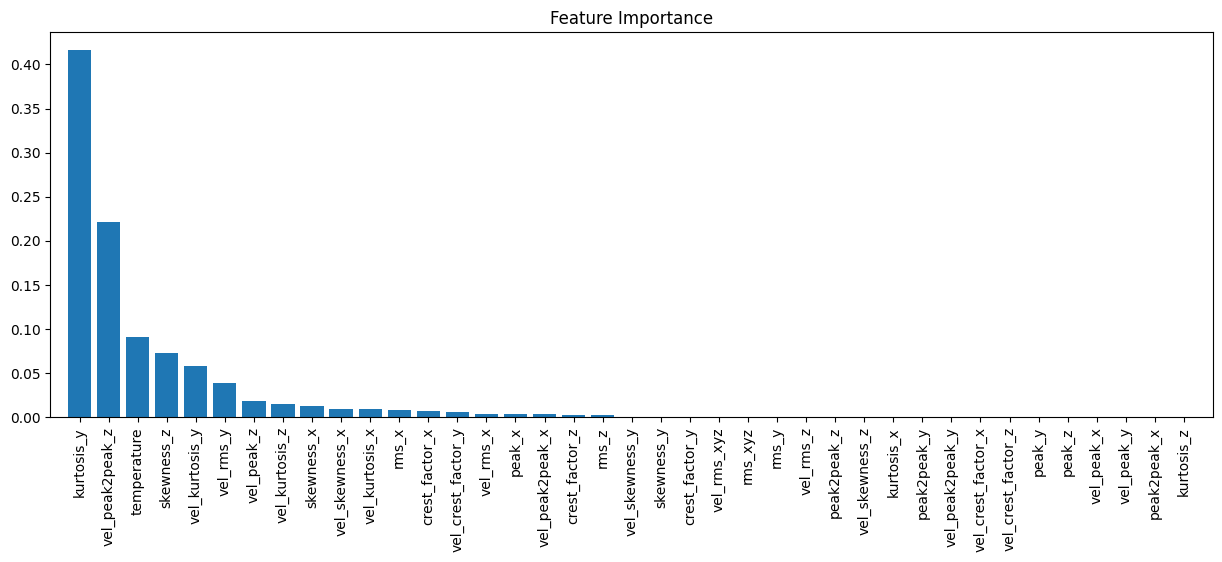

In [7]:
reg = RandomForestRegressor(max_depth=2, min_samples_split=12)
reg.fit(X, y)

reg_imp = reg.feature_importances_

indices = np.argsort(reg_imp)[::-1]
plt.figure(figsize=(15, 5))
plt.title('Feature Importance')
plt.bar(range(X.shape[1]), reg_imp[indices], align='center')
plt.xticks(range(X.shape[1]), np.array(features)[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()